# `'GB1_biophysical_model'`

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Special imports
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, '/home/mahdik/workspace/mavenn')
import mavenn
print(mavenn.__path__)
from tqdm.keras import TqdmCallback # For better training progress visualization

['/Users/jkinney/github/mavenn/mavenn']


Here we show how to train and visualize the thermodynamic model for IgG binding by GB1, which is featured in Fig. 6 of Tareen et al.
(2021). The model is trained on the dataset provided with MAVE-NN, `'gb1'`.

## Training

First we choose the `'gb1'` dataset we want to use and load it. We also compute the length of sequences in that dataset, as we will need this quantity for defining the architecture of our model.

In [2]:
# Choose dataset
data_name = 'gb1'
print(f"Loading dataset '{data_name}' ")

# Load datset
data_df = mavenn.load_example_dataset(data_name)

# Get and report sequence length
L = len(data_df.loc[0,'x'])
print(f'Sequence length: {L:d} amino acids')

# Preview dataset
data_df

Loading dataset 'gb1' 
Sequence length: 55 amino acids


,set,dist,input_ct,selected_ct,y,x
0,training,2,173,33,-3.145154,AAKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,validation,2,18,8,-1.867676,ACKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,validation,2,66,2,-5.270800,ADKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
3,training,2,72,1,-5.979498,AEKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,training,2,69,168,0.481923,AFKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
...,...,...,...,...,...,...
530732,training,2,462,139,-2.515259,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
530733,training,2,317,84,-2.693165,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
530734,training,2,335,77,-2.896589,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
530735,test,2,148,28,-3.150861,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


Next we split data into a training+validation set called `trainval_df`, and a
test set called `test_df`, using the built-in function `mavenn.split_dataset()`.

In [3]:
# Split dataset
trainval_df, test_df = mavenn.split_dataset(data_df)

# Show dataset sizes
print(f'Train + val set size : {len(trainval_df):6,d} observations')
print(f'Test set size        : {len(test_df):6,d} observations')

# Preview trainval_df
trainval_df

Train + val set size : 424,675 observations
Test set size        : 106,062 observations


,validation,dist,input_ct,selected_ct,y,x
0,False,2,173,33,-3.145154,AAKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,True,2,18,8,-1.867676,ACKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,True,2,66,2,-5.270800,ADKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
3,False,2,72,1,-5.979498,AEKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,False,2,69,168,0.481923,AFKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
...,...,...,...,...,...,...
424670,True,2,151,30,-3.083405,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
424671,False,2,462,139,-2.515259,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
424672,False,2,317,84,-2.693165,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
424673,False,2,335,77,-2.896589,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


### Building Thermodynamic Model
The goal of the biophysical model for IgG binding by GB1 is to estimate the GB1 folding energy (relative to unfolded state energy), $\Delta G_F$, and IgG-GB1 binding energy, $\Delta G_B$.
Using quasi-equilibrium assumption, one can define the three-microsstate model summerized in the table below: 

|    microstates   |    Gibbs free energies   |
|:----------------:|:------------------------:|
|     unfolded     |             0            |
| folded-unbound   |       $\Delta G_F$       |
|  folded-bound    | $\Delta G_F +\Delta G_B$ |

To fit thermodynamic models, one can use the special **Custom G-P maps** layer implemented in `'mavenn.src.layers.gpmap'`. The implementation of this layer is similar to using custom layers in native `tensorflow` framework and consists of the following steps:

1. Import some of built-in `tensorflow` functionalities and abstractions in our script. 
2. Define the super-class thermodynamic layer of the type `CustomGPMapLayer`: here it is called `class ThermodynamicLayer(CustomGPMapLayer)`.
    - in the initialization step (`__init__` function) we can specify the overal parameters such as sequence length `L`, sequence alphabet `C` and neural-network weights regularizations `tf.keras.regularizers.L2`.

3. Next, we need to build our layer. The Gibs free energies can be defined as a linear function of the sequence space with the form $G = \mu_{i} + \vec{\theta_i} X$.
    - $\mu$ is the chemical potential
    - $x$ is the one-hot encoded representation of the sequences.
    - $i={f, b}$ representing folded and bounded microstates, respectively.
    - Set of trainable G-P map parameters is $\{\mu_f, \vec{\theta_f}, \mu_B, \vec{\theta_b} \}$ which are the weights in our neural-network setup. 
4. The output of the layer should be our measurement, rate of the transcription `p_fb`, which has the notion of the probability of folded-bound state:

$
p_{fb} = \frac{\exp(-G_f-G_b)}{1+\exp(-G_f)+ \exp(-G_f-G_b)}
$

In [33]:
from mavenn.src.layers.gpmap import CustomGPMapLayer


# Tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Layer, Dense

class ThermodynamicLayer(CustomGPMapLayer):
    """
    Represents a three stage thermodynamic model
    containing the states:
    1. unfolded 
    2. folded-unbound
    3. folded-bound
    """

    def __init__(self, 
                 L,
                 C,
                 regularizer, 
                 *args, **kwargs):
        """Construct layer instance."""
        
        # set attributes
        self.L = L # sequence length.
        self.C= C  # sequence alphabets
        self.regularizer = tf.keras.regularizers.L2(regularizer)
        
        super().__init__(*args, **kwargs)

    def build(self, input_shape):
        """Build layer."""
        
        # define bias/chemical potential weight for folding energy
        self.theta_f_0 = self.add_weight(name='theta_f_0',
                                         shape=(1,),
                                         initializer=Constant(1.),
                                         trainable=True,
                                         regularizer=self.regularizer)

        # define bias/chemical potential weight for binding energy
        self.theta_b_0 = self.add_weight(name='theta_b_0',
                                         shape=(1,),
                                         initializer=Constant(1.),
                                         trainable=True,
                                         regularizer=self.regularizer)


        # Define theta_binding_lc parameters
        theta_b_lc_shape = (1, self.L, self.C)

        theta_b_lc_init = np.random.randn(*theta_b_lc_shape)/np.sqrt(self.L)
        self.theta_b_lc = self.add_weight(name='theta_b_lc',
                                        shape=theta_b_lc_shape,
                                        initializer=Constant(theta_b_lc_init),
                                        trainable=True,
                                        regularizer=self.regularizer)
        
        # Define theta_folding_lc parameters
        theta_f_lc_shape = (1, self.L, self.C)

        theta_f_lc_init = np.random.randn(*theta_f_lc_shape)/np.sqrt(self.L)
        self.theta_f_lc = self.add_weight(name='theta_f_lc',
                                          shape=theta_f_lc_shape,
                                          initializer=Constant(theta_f_lc_init),
                                          trainable=True,
                                          regularizer=self.regularizer)

        
        # Call superclass build
        super().build(input_shape)

    def call(self, x_lc):
        """Process layer input and return output.
        
        x_lc: (tensor)
            Input tensor that represents one-hot encoded 
            sequence values. 
        """
        
        # reshape sequence to samples x length x characters
        x_lc = tf.reshape(x_lc, [-1, self.L, self.C])
        
        # compute delta G for binding    
        G_b = self.theta_b_0 + \
              tf.reshape(K.sum(self.theta_b_lc * x_lc, axis=[1, 2]),
                         shape=[-1, 1])
            
        # compute delta G for folding
        G_f = self.theta_f_0 + \
              tf.reshape(K.sum(self.theta_f_lc * x_lc, axis=[1, 2]),
                         shape=[-1, 1])            
        
        # compute p_fb
        p_fb = (K.exp(-G_f-G_b))/(1+K.exp(-G_f)+K.exp(-G_f-G_b))
        
        # return rate of transcription
        return p_fb

    def set_params(self, **kwargs):
        """Set values of layer parameters."""
        assert False

    def get_params(self):

        """Get values of layer parameters."""
        param_dict = {}
        param_dict['theta_b_0'] = np.float(self.theta_b_0)
        param_dict['theta_f_0'] = np.float(self.theta_f_0)
        param_dict['theta_b_lc'] = np.squeeze(self.theta_b_lc)
        param_dict['theta_f_lc'] = np.squeeze(self.theta_f_lc)
        return param_dict

In [32]:
# Try to extract params
nn = model.get_nn()
layer = nn.layers[2]
np.squeeze(layer.theta_b_lc)

model.layer_gpmap.get_params()

AssertionError: 

### Training the Model
Now we create an instance of the `mavenn.Model` class, called `model`, using the following keyword arguments:

- `L=L` specifies sequence length.
- `alphabet='protein'` specifies that the alphabet our sequences are built from consists of 20 characters representing the 20 amino acids.
- `gpmap_type='custom'` specifies that we wish to infer an custom G-P map.
- `regression_type='GE'` specifies that our model will have a global epistasis (GE) measurement process. We choose this because our MAVE measurements are continuous real numbers.
- `ge_noise_model_type='SkewedT'` specifies the use of a skewed-t noise model in the GE measurement process. The `'SkewedT'` noise model can accommodate asymmetric noise and is thus more flexible than the default `'Gaussian'` noise model.
- `ge_heteroskedasticity_order=2` specifies that the noise model parameters (the three parameters of the skewed-t distribution) are each modeled using quadratic functions of the predicted measurement $\hat{y}$. This will allow our model of experimental noise to vary with signal intensity.


We then set the training data by calling `model.set_data()`. The keyword argument `'validation_flags'` is used to specify which subset of the data in `trainval_df` will be used for validation (as opposed to stochastic gradient descent).

Next we train the model by calling `model.fit()`. In doing so we specify a number of hyperparameters including the learning rate, the number of epochs, the batch size, whether to use early stopping, and the early stopping patience.  We also set `verbose=False` to limit the amount of user feedback.

Choosing hyperparameters is somewhat of an art, and the particular values used here were found by trial and error. In general users will have to try a number of different values for these and possibly other hyperparameters in order to find ones that work well. We recommend that users choose these hyperparameters in order to maximize the final value for `val_I_var`, the variational information of the trained model on the validation dataset.

In [35]:
# define custom gp_map parameters dictionary
gpmap_kwargs = {'L':L,
                'C':20, # 
                'regularizer':0.05}

# Create model instace
model = mavenn.Model(L=L, 
                     alphabet='protein', 
                     regression_type='GE', 
                     gpmap_type='custom',
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2,
                     gpmap_kwargs=gpmap_kwargs,
                     custom_gpmap=ThermodynamicLayer)

# Set training data
model.set_data(x=trainval_df['x'],
               y=trainval_df['y'],
               validation_flags=trainval_df['validation'])

# Train model
model.fit(learning_rate=.001,
          epochs=10,
          batch_size=1024,
          early_stopping=True,
          early_stopping_patience=25,
          verbose=False,
          callbacks=[TqdmCallback(verbose=0)]);


N = 424,675 observations set as training data.
Using 25.0% for validation.
Data shuffled.
Time to set data: 7.17 sec.


0epoch [00:00, ?epoch/s]

To assess the performance of our final trained model, we compute two different metrics on test data: **variational information** and **predictive information**. Variational information quantifies the performance of the full latent phenotype model, whereas predictive information quantifies the performance of just the G-P map portion of the model. See Tareen et al. (2021) for an expanded discussion of these quantities.

Note that MAVE-NN also estimates the standard errors for these quantities.

In [36]:
# Compute predictive information on test data
I_pred, dI_pred = model.I_predictive(x=test_df['x'], y=test_df['y'])
print(f'test_I_pred: {I_pred:.3f} +- {dI_pred:.3f} bits')

test_I_pred: 2.113 +- 0.004 bits


To save the trained model we call `model.save()`. This records our model in **two separate files**: a pickle file that defines model architecture (extension `'.pickle'`), and an H5 file that records model parameters (extension `'.h5'`).

In [7]:
# Save model to file
model_name = f'{data_name}_thermodynamic'
model.save(model_name)

Model saved to these files:
	gb1_thermodynamic.pickle
	gb1_thermodynamic.h5


## Visualization

We now discuss how to visualize the training history, performance, and parameters of a trained model. First we  then load our model using `mavenn.load`:

In [8]:
# Delete model if it is present in memory
try:
    del model
except:
    pass

# Load model from file
model = mavenn.load(model_name)

Model loaded from these files:
	gb1_thermodynamic.pickle
	gb1_thermodynamic.h5


The `model.history` dictionary contains values for multiple model performance metrics, evaluated on both the training data and the validation data, as a function of training epoch. `'loss'` and `'val_loss'` record loss values, while `'I_var'` and `'val_I_var'` record the variational information values. As described in Tareen et al. (2021), these metrics are closely related: variational information is an affine transformation of model likelihood, whereas loss is equal to likelihood plus regularization terms.

In [9]:
# Show metrics recorded in model.history()
model.history.keys()

dict_keys(['loss', 'I_var', 'val_loss', 'val_I_var'])

Plotting `'I_var'` and `'val_I_var'` versus epoch can often provide insight into the model training process.

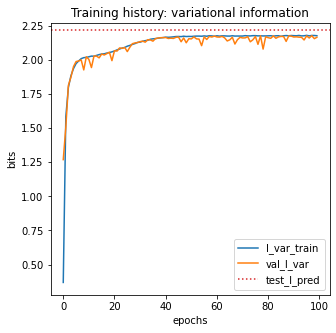

In [10]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1,1,figsize=[5,5])

# Plot I_var_train, the variational information on training data as a function of epoch
ax.plot(model.history['I_var'],
        label=r'I_var_train')

# Plot I_var_val, the variational information on validation data as a function of epoch
ax.plot(model.history['val_I_var'],
        label=r'val_I_var')

# Show I_pred_test, the predictive information of the final model on test data
ax.axhline(I_pred, color='C3', linestyle=':',
           label=r'test_I_pred')

# Style plot
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('Training history: variational information')
ax.legend()

From this plot we observe a few things:

- `'val_I_var'` quickly converges to its final value, suggesting that model training has likely gone to completion.
- `'I_var'` is noticably higher than `'val_I_var'`, which is indicative of overfitting. But these two quantities largely remain monotonically related to one another, indicating that this overfitting is likely begnin.
- `'test_I_var'` is quite close to `'test_I_pred'` indicating that the inferred measurement process does a good job of describing the scatter of $y$ about $\hat{y}$.

Users can plot '`loss`' and '`var_loss`' if they like, though the absolute values these quantities are be more difficult to interpret than `'I_var'` and `'val_I_var'`.

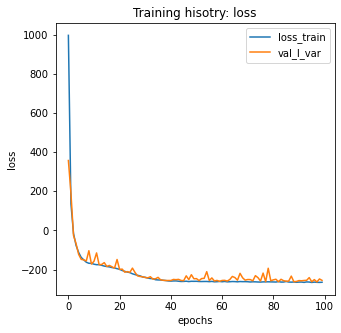

In [11]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1,1,figsize=[5,5])

# Plot loss_train, the loss computed on training data as a function of epoch
ax.plot(model.history['loss'],
        label=r'loss_train')

# Plot loss_val, the loss computed on validation data as a function of epoch
ax.plot(model.history['val_loss'],
        label=r'val_I_var')

# Style plot
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title('Training hisotry: loss')
ax.legend()

It is also useful to consider more traditional metrics of model performance. In the context of GE models, a natural choice is $R^2$ between measurements $y$ and model predictions $\hat{y}$:

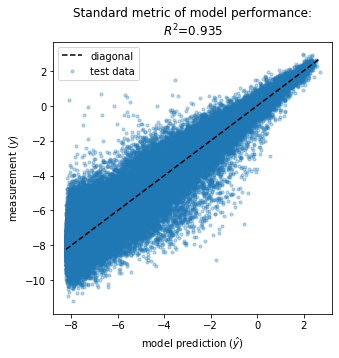

In [12]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1,1,figsize=[5,5])

# Get test data y values
y_test = test_df['y']

# Compute yhat on test data
yhat_test = model.x_to_yhat(test_df['x'])

# Compute R^2 between yhat_test and y_test
Rsq = np.corrcoef(yhat_test.ravel(), test_df['y'])[0, 1]**2

# Plot y_test vs. yhat_test
ax.scatter(yhat_test, y_test, color='C0', s=10, alpha=.3,
           label='test data')

# Style plot
xlim = [min(yhat_test), max(yhat_test)]
ax.plot(xlim, xlim, '--', color='k', label='diagonal', zorder=100)
ax.set_xlabel('model prediction ($\hat{y}$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'Standard metric of model performance:\n$R^2$={Rsq:.3}');
ax.legend()

Next we visualize the GE measurement process inferred as part of our latent phenotype model. Recall from Tareen et al. (2021) that the measurement process consists of

- A nonlinearity $\hat{y} = g(\phi)$ that deterministically maps the latent phenotype $\phi$ to a prediction $\hat{y}$.
- A noise model $p(y|\hat{y})$ that stochastically maps predictions $\hat{y}$ to measurements $y$.

We can conveniently visualize both of these quantities in a single "global epistatsis plot":

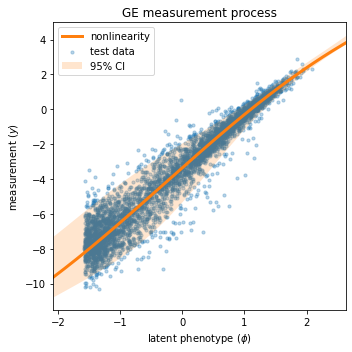

In [18]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1,1,figsize=[5,5])

# Get test data y values
y_test = test_df['y']
#dy_test = test_df['dy']

# Compute φ on test data
phi_test = model.x_to_phi(test_df['x'])

## Set phi lims and create a grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 95% CI for each yhat
q = [0.025, 0.975]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)


# Plot scatter of φ and y values.
ix = np.random.choice(a=len(phi_test), size=5000, replace=False)
ax.scatter(phi_test[ix], y_test[ix],
           color='C0', s=10, alpha=.3, label='test data')

# Plote 95% confidence interval
ax.fill_between(phi_grid, yqs_grid[:, 0], yqs_grid[:, 1],
                alpha=0.2, color='C1', lw=0, label='95% CI')

# Plot GE nonlinearity
ax.plot(phi_grid, yhat_grid,
        linewidth=3, color='C1', label='nonlinearity')

# Style plot
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('GE measurement process')
ax.legend()
fig.tight_layout()

To retrieve the values of our model's G-P map parameters, we use the mmethod `model.get_theta()`. This returns a dictionary:

In [39]:
# Retrieve G-P map parameter dict and view dict keys
theta_dict = model.layer_gpmap.get_params()
theta_dict.keys()


dict_keys(['theta_b_0', 'theta_f_0', 'theta_b_lc', 'theta_f_lc'])

It is important to appreciate that G-P maps usually have many non-identifiable directions in parameter space. These are called "gauge freedoms".  Interpreting the values of model parameters requires that we first "pin down" these gauge freedoms by using a clearly specified convension. Specifying `gauge='consensus'` in `model.get_theta()` accomplishes this fixing all the $\theta_{l:c}$ parameters that contribute to the consensus sequence to zero. This convension allows all the other $\theta_{l:c}$ parameters in the additive model to be interpreted as single-mutation effects $\Delta \phi$ away from the consensus sequence.

Finally, we use `mavenn.heatmap()` to visualize these additive parameters. This function takes a number of keyword arguments, which we summarize here. More information can be found in this function's docstring.

- `ax=ax`: specifies the axes on which to draw both the heatmap and the colorbar.
- `values=theta_dict['theta_lc']`: specifies the additive parameters in the form of a `np.array` of size `L`x`C`, where `C` is the alphabet size.
- `alphabet=theta_dict['alphabet']`: provides a list of characters corresponding to the columns of `values`.
- `seq=model.x_stats['consensus_seq']`: causes `mavenn.heatmap()` to highlight the characters of a specific sequence of interest. In our case this is the consensus sequence, the additive parameters for which are all fixed to zero.
- `seq_kwargs={'c':'gray', 's':25}`: provides a keyword dictionary to pass to `ax.scatter()`; this specifies how the characters of the sequence of interest are to be graphically indicated.
- `cmap='coolwarm'`: specifies the colormap used to represent the values of the additive parameters.
- `cbar=True`: specifies that a colorbar be drawn
- `cmap_size='2%'`: specifies the width of the colorbar relative to the enclosing ax object.
- `cmap_pad=.3`: specifies the spacing between the heatmap and the colorbar
- `ccenter=0`: centers the colormap at zero.

This function returns two objects:
- `heatmap_ax` is the axes object on which the heatmap is drawn.
- `cb` is the colorbar object; it's corresponding axes is given by `cb.ax`.


In [51]:
from mavenn.src.utils import _x_to_mat
gb1_seq = model.x_stats['consensus_seq']
x_lc_cons = _x_to_mat(gb1_seq, model.alphabet)
ddG_b = theta_dict['theta_b_lc'] - np.sum(x_lc_cons*theta_dict['theta_b_lc'], axis=1)[:,np.newaxis]
ddG_f = theta_dict['theta_f_lc'] - np.sum(x_lc_cons*theta_dict['theta_f_lc'], axis=1)[:,np.newaxis]

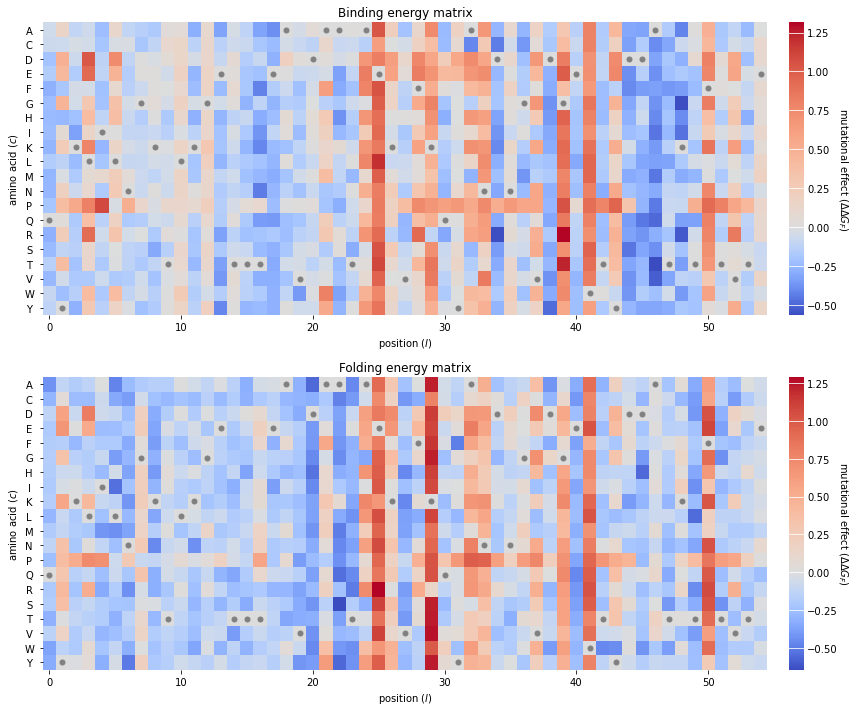

In [52]:
# Create figure
fig, axs = plt.subplots(2,1, figsize=(12,10))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[0],
                                values=ddG_b,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Binding energy matrix')

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \Delta G_F$)', labelpad=5, rotation=-90, ha='center', va='center')

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[1],
                                values=ddG_f,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Folding energy matrix')


# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \Delta G_F$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)

Note that many of the squares in the heatmap are white. These correspond to additive parameters whose values are `NaN`. MAVE-NN sets the values of a feature effect to `NaN` when no variant in the training set exhibits that feature. Such `NaN` parameters are common, even among additive parameters, as DMS libraries often do not contain a comprehensive set of single-amino-acid mutations.

## References

1. Tareen, A., Posfai, A., Ireland, W. T., McCandlish, D. M. & Kinney, J. B. MAVE-NN: learning genotype-phenotype maps from multiplex assays of variant effect. bioRxiv doi:10.1101/2020.07.14.201475 (2020).
1. Seuma, M., Faure, A., Badia, M., Lehner, B. & Bolognesi, B. The genetic landscape for amyloid beta fibril nucleation accurately discriminates familial Alzheimer’s disease mutations. eLife 10, e63364 (2021).

